In [1]:

import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

plt.style.use('seaborn-darkgrid')

In [2]:
 #Data comes from:
# https://finance.yahoo.com/quote/ETH-USD/history?period1=1438905600&period2=1660694400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

root_path='/content/ETH-USD PRED.csv'

ETH_df = pd.read_csv(root_path)
ETH_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1738,2022-08-13,1957.333984,2013.755737,1948.595215,1981.336548,1981.336548,16038975216
1739,2022-08-14,1981.782471,2022.791504,1919.010132,1936.802002,1936.802002,14062754456
1740,2022-08-15,1936.760498,2007.210327,1881.856812,1904.228149,1904.228149,20349931313
1741,2022-08-16,1902.833130,1910.745361,1862.273438,1878.139404,1878.139404,15637578930
1742,2022-08-17,1876.656494,1951.675659,1823.532227,1838.366943,1838.366943,19144841216


In [3]:
ETH_df.shape

(1743, 7)

In [4]:
ETH_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1743 entries, 0 to 1742
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1743 non-null   object 
 1   Open       1743 non-null   float64
 2   High       1743 non-null   float64
 3   Low        1743 non-null   float64
 4   Close      1743 non-null   float64
 5   Adj Close  1743 non-null   float64
 6   Volume     1743 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 95.4+ KB


In [5]:
#Converting 'Date' column from object dtype to datetime dtype
ETH_df_date = ETH_df.astype({'Date': 'datetime64'})
ETH_df_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1743 entries, 0 to 1742
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1743 non-null   datetime64[ns]
 1   Open       1743 non-null   float64       
 2   High       1743 non-null   float64       
 3   Low        1743 non-null   float64       
 4   Close      1743 non-null   float64       
 5   Adj Close  1743 non-null   float64       
 6   Volume     1743 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 95.4 KB


In [6]:
print('Null Values:',ETH_df_date.isnull().values.sum())


Null Values: 0


In [7]:
ETH_df_date.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1738,2022-08-13,1957.333984,2013.755737,1948.595215,1981.336548,1981.336548,16038975216
1739,2022-08-14,1981.782471,2022.791504,1919.010132,1936.802002,1936.802002,14062754456
1740,2022-08-15,1936.760498,2007.210327,1881.856812,1904.228149,1904.228149,20349931313
1741,2022-08-16,1902.833130,1910.745361,1862.273438,1878.139404,1878.139404,15637578930
1742,2022-08-17,1876.656494,1951.675659,1823.532227,1838.366943,1838.366943,19144841216


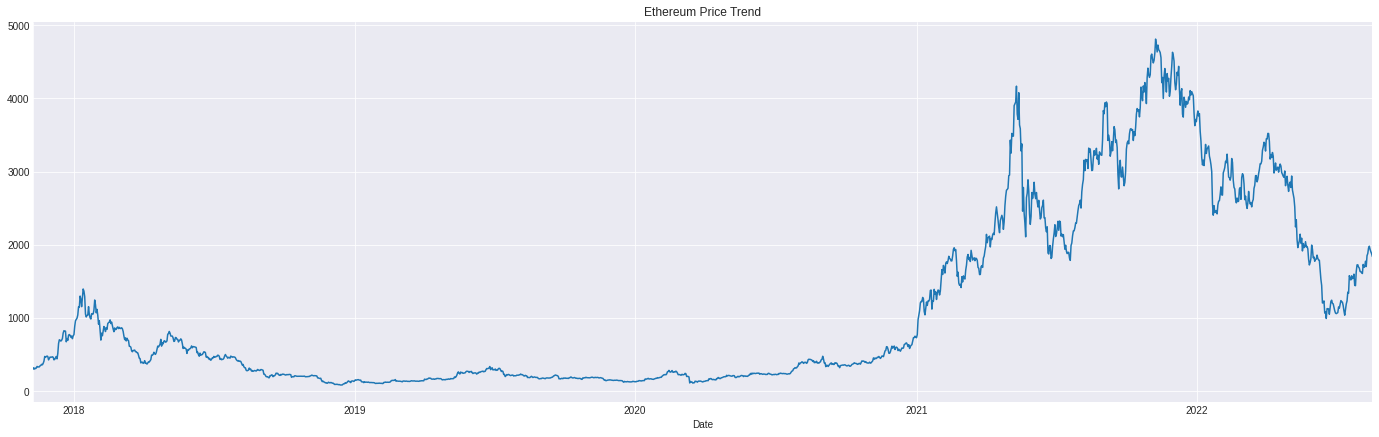

In [8]:
ETH_df_date.set_index("Date").Close.plot(figsize=(24,7), title="Ethereum Price Trend")

In [9]:
ETH_Date=ETH_df_date.groupby('Date')
Price_by_date=ETH_Date['Close'].mean()
Price_by_date

Date
2017-11-09     320.884003
2017-11-10     299.252991
2017-11-11     314.681000
2017-11-12     307.907990
2017-11-13     316.716003
                 ...     
2022-08-13    1981.336548
2022-08-14    1936.802002
2022-08-15    1904.228149
2022-08-16    1878.139404
2022-08-17    1838.366943
Name: Close, Length: 1743, dtype: float64

In [10]:
len(Price_by_date)

1743

In [11]:
prediction_days = 120 #to divide train and test 

# Creating training dataset
df_train= Price_by_date[:len(Price_by_date)-prediction_days].values.reshape(-1,1)


# Test the last prediction_days 
df_test= Price_by_date[len(Price_by_date)-prediction_days:].values.reshape(-1,1)

In [12]:
df_test.shape,df_train.shape

((120, 1), (1623, 1))

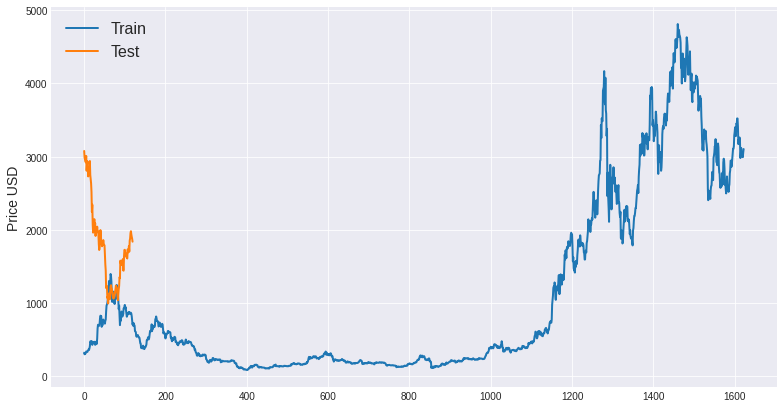

In [13]:
chosen_col = 'Close'

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df_train, label='Train', linewidth=2)
ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [14]:
#scaling the data
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [15]:
#splitting the input sequence into windows of data

def dataset_period(dataset, back=5):
     
    dataX, dataY = [], []
    
    for i in range(len(dataset) - back):
        window = dataset[i:(i + back), 0]#getting windows of 5 timestamp each
        dataX.append(window)
        dataY.append(dataset[i + back, 0]) #getting the labels for each window
    return np.array(dataX), np.array(dataY)

X_train, y_train = dataset_period(scaled_train)

X_test, y_test= dataset_period(scaled_test)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1618, 5)
y_train:  (1618,)
X_test:  (115, 5)
y_test (115,)


In [16]:
#need to reshape input to be a 3D Tensor
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (1618, 5, 1)
Shape of X_test:  (115, 5, 1)


In [17]:
#using an LMST model
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))#set return_sequences=True 
model.add(Dropout(0.2))#regularisation

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 64, input_shape = (X_train.shape[1], X_train.shape[2]))) 
model.add(Dropout(0.2))


# Adding the output layer
model.add(Dense(units = 1))



In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

checkpoint_path = 'best_model.hdf5'#for saving best model

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]
#testing the model
history = model.fit(X_train, y_train, batch_size = 32, epochs = 200, verbose=1, shuffle=False,  validation_split=0.2, callbacks=callbacks)

Epoch 1/200
40/41 [============================>.] - ETA: 0s - loss: 0.0168
Epoch 1: val_loss improved from inf to 0.25425, saving model to best_model.hdf5
41/41 [==============================] - 10s 80ms/step - loss: 0.0184 - val_loss: 0.2543
Epoch 2/200
40/41 [============================>.] - ETA: 0s - loss: 0.0143
Epoch 2: val_loss improved from 0.25425 to 0.14062, saving model to best_model.hdf5
41/41 [==============================] - 1s 34ms/step - loss: 0.0151 - val_loss: 0.1406
Epoch 3/200
41/41 [==============================] - ETA: 0s - loss: 0.0043
Epoch 3: val_loss improved from 0.14062 to 0.00223, saving model to best_model.hdf5
41/41 [==============================] - 2s 39ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 4/200
40/41 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 4: val_loss did not improve from 0.00223
41/41 [==============================] - 1s 28ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 5/200
40/41 [============================>

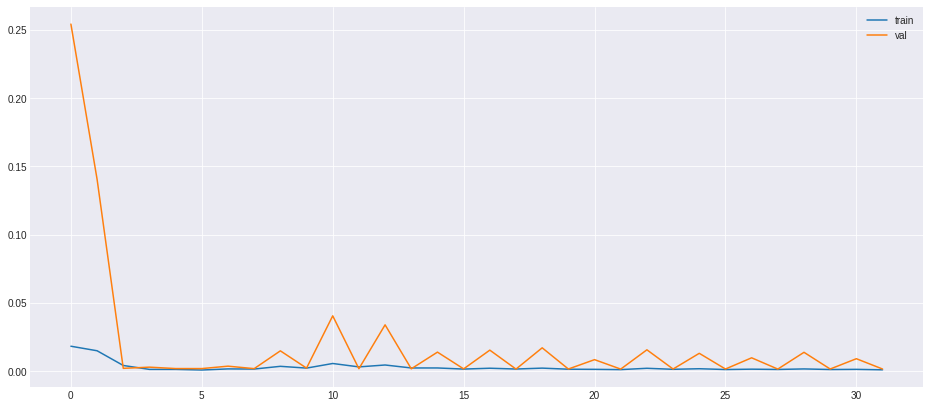

In [20]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [21]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path) #loading best model




In [22]:
# Transformation to original form and making the predictions on test
pred_ETH_test = model_from_saved_checkpoint.predict(X_test)
pred_ETH_test = scaler_test.inverse_transform(pred_ETH_test.reshape(-1, 1))
test_actual = scaler_test.inverse_transform(y_test.reshape(-1, 1))

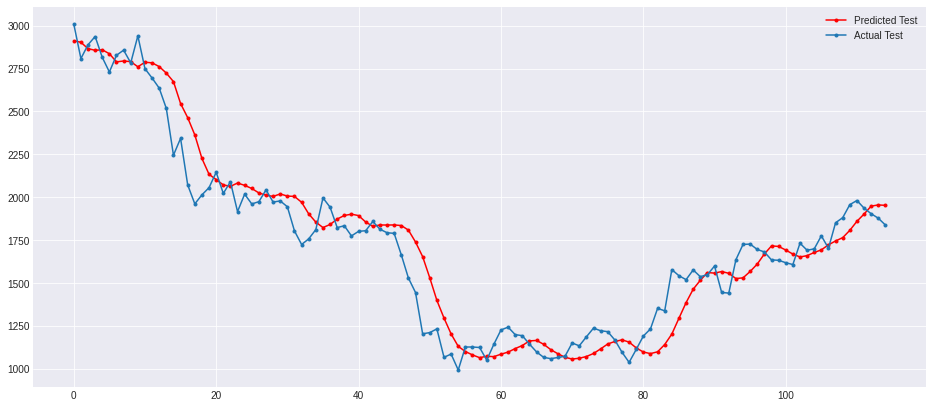

In [23]:
plt.figure(figsize=(16,7))
plt.plot(pred_ETH_test, 'r', marker='.', label='Predicted Test')
plt.plot(test_actual, marker='.', label='Actual Test')
plt.legend()
plt.show()

In [24]:
# Transformation to original form and making the predictions on train
pred_ETH_train = model_from_saved_checkpoint.predict(X_train)
pred_ETH_train = scaler_train.inverse_transform(pred_ETH_train.reshape(-1, 1))
train_actual = scaler_train.inverse_transform(y_train.reshape(-1, 1))

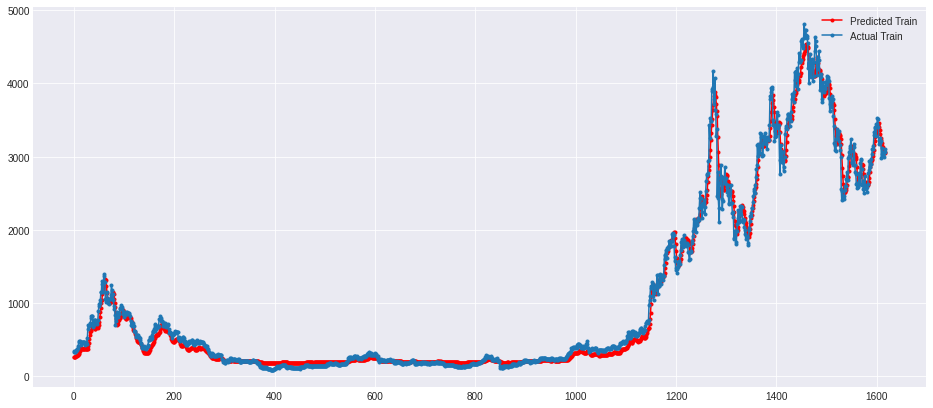

In [25]:
plt.figure(figsize=(16,7))
plt.plot(pred_ETH_train, 'r', marker='.', label='Predicted Train')
plt.plot(train_actual, marker='.', label='Actual Train')
plt.legend()
plt.show()

In [26]:
#RMSE on test
rmse_lstm_test =math.sqrt(mean_squared_error(test_actual, pred_ETH_test))

print('Test RMSE: %.3f' % rmse_lstm_test)




Test RMSE: 143.345


In [27]:
#RMSE on train
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, pred_ETH_train))

print('train RMSE: %.3f' % rmse_lstm_train)


train RMSE: 123.605


# PRICE PREDICTION ON FUTURE 5 DAYS


In [28]:
#putting into the model the past 'back_period' values and getting future values as output.
back_period = 5 

X_test_last_5_days = X_test[X_test.shape[0] - back_period :  ]

X_test_last_5_days.shape

(5, 5, 1)

In [29]:
X_test_last_5_days

array([[[0.37516239],
        [0.34037962],
        [0.41173752],
        [0.42588334],
        [0.46236048]],

       [[0.34037962],
        [0.41173752],
        [0.42588334],
        [0.46236048],
        [0.47391942]],

       [[0.41173752],
        [0.42588334],
        [0.46236048],
        [0.47391942],
        [0.4525508 ]],

       [[0.42588334],
        [0.46236048],
        [0.47391942],
        [0.4525508 ],
        [0.43692117]],

       [[0.46236048],
        [0.47391942],
        [0.4525508 ],
        [0.43692117],
        [0.42440323]]])

In [30]:
predicted_5_days_price_test = []

for i in range(5):  
  predicted_price_test = model_from_saved_checkpoint.predict(X_test_last_5_days[i:i+1]) 
  predicted_price_test = scaler_test.inverse_transform(predicted_price_test.reshape(-1, 1))
  predicted_5_days_price_test.append(predicted_price_test)
print("prediction ", np.array(predicted_5_days_price_test)) #predicting 5 future days 

prediction  [[[1860.1904]]

 [[1902.4188]]

 [[1948.6348]]

 [[1955.455 ]]

 [[1953.1792]]]


In [31]:
predicted_5_days_price_test = np.array(predicted_5_days_price_test)

predicted_5_days_price_test.shape

(5, 1, 1)

In [32]:
predicted_5_days_price_test

array([[[1860.1904]],

       [[1902.4188]],

       [[1948.6348]],

       [[1955.455 ]],

       [[1953.1792]]], dtype=float32)

In [33]:
predicted_5_days_price_test = predicted_5_days_price_test.flatten()

predicted_5_days_price_test

array([1860.1904, 1902.4188, 1948.6348, 1955.455 , 1953.1792],
      dtype=float32)

In [34]:
pred_ETH_test = pred_ETH_test.flatten()

pred_ETH_test

array([2912.4731, 2903.3137, 2866.0508, 2856.719 , 2859.5662, 2836.5645,
       2789.2095, 2794.206 , 2790.5696, 2760.6655, 2787.0269, 2783.495 ,
       2761.683 , 2723.6023, 2674.1929, 2546.4744, 2463.978 , 2363.4832,
       2226.2654, 2133.918 , 2103.3345, 2072.1807, 2064.0054, 2083.0637,
       2069.6406, 2051.395 , 2025.4354, 2012.3156, 2005.2576, 2019.4271,
       2007.1276, 2005.054 , 1970.9136, 1903.2611, 1855.2738, 1823.756 ,
       1841.5922, 1873.2126, 1894.1576, 1901.6047, 1893.4968, 1855.8658,
       1830.8795, 1838.6866, 1838.4402, 1838.8721, 1835.5575, 1808.8165,
       1739.535 , 1654.2007, 1530.9131, 1399.3014, 1296.4152, 1203.6144,
       1131.3992, 1101.2832, 1081.5841, 1065.5321, 1073.825 , 1071.4565,
       1085.7544, 1097.9985, 1118.4509, 1136.4089, 1163.2327, 1165.8817,
       1143.4012, 1112.2323, 1088.251 , 1067.8069, 1057.5747, 1062.0433,
       1072.2518, 1089.8635, 1116.6799, 1145.3579, 1159.8246, 1169.3563,
       1156.2346, 1122.4646, 1098.3506, 1089.2355, 

In [35]:
pred_ETH_test_concatenated = np.concatenate((pred_ETH_test, predicted_5_days_price_test))

pred_ETH_test_concatenated

pred_ETH_test_concatenated.shape

(120,)

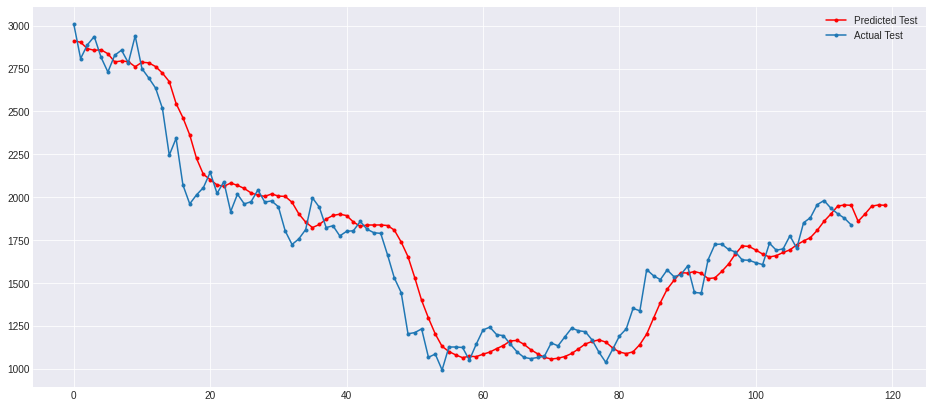

In [36]:
# Predictions of Test Data (including the Future 5-days )
plt.figure(figsize=(16,7))

plt.plot(pred_ETH_test_concatenated, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()

plt.show()